In [1]:
from k1lib.imports import *

In [2]:
class Network(nn.Module): pass

## l-0.pth

In [5]:
l = k1lib.Learner.load("autosave-2.pth"); l.model

Loaded from autosave-2.pth


Network(
  (bulk): Sequential(
    (0): Linear(in_features=1, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=10, bias=True)
    (3): ReLU()
    (4): Linear(in_features=10, out_features=10, bias=True)
    (5): ReLU()
    (6): Linear(in_features=10, out_features=1, bias=True)
  )
)

This one goes to exponential pretty hard at batch 200-400 or sth like that. This is because lossF is actually just `lambda x, y: x.mean()`. So all backward passes actually don't contain any kind of information, and so pretty much every interaction and weight domination effect is reinforced without bounds, and just explodes upwards. Kinda like how bateria can grow exponentially.

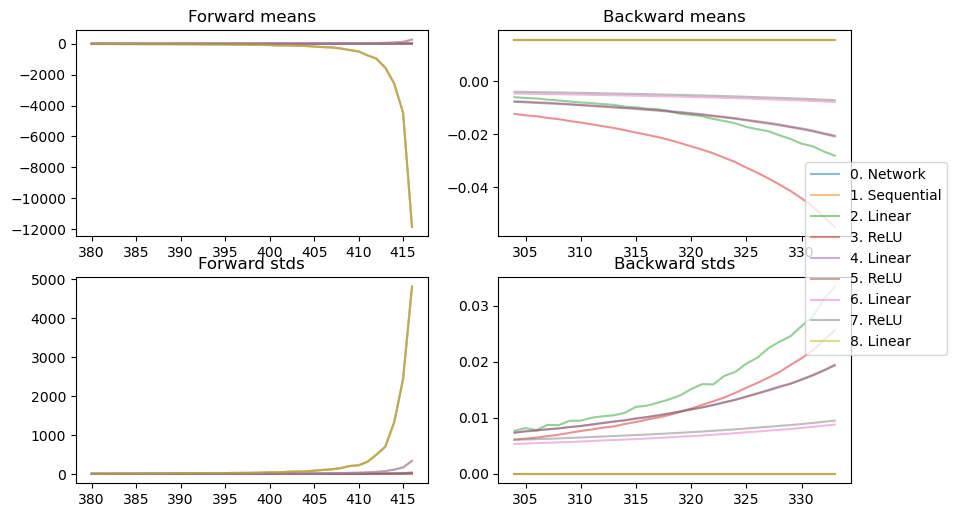

Sliceable plot. Can...
- p[a:b]: to focus on a specific range of the plot
- p.log: to display plot using log scale

In [21]:
l.HookModule.plot()[380:417] # showing backward pass always stays the same

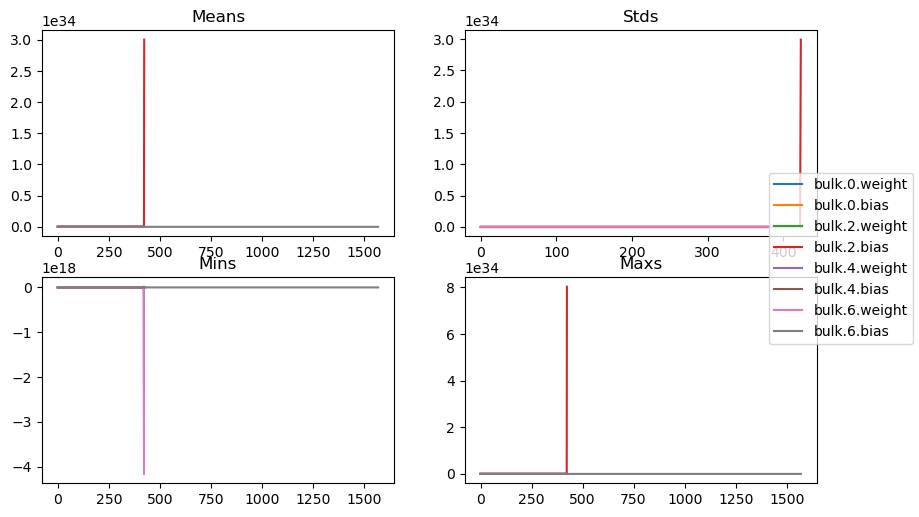

Sliceable plot. Can...
- p[a:b]: to focus on a specific range of the plot

In [27]:
l.HookParam.plot()[:10]

Sometimes `bulk.0.weight` and `bulk.6.weight` goes together toward $\pm\infty$, sometimes they go their separate paths. Interesting that it's always the first and last `nn.Linear` to lead the way, and not anywhere else in the middle. So don't expect that stuff will change a lot there.

How about the explosion rate? Can we quantify it?

In [ ]:
def doubleLog(arr): return np.log(np.maximum(np.log(arr), 1))
def plot():
    a = np.array(l.HookParam[0].data.means); a = a[~np.isnan(a)]
    b = np.abs(l.HookModule[0].data.forward.means); b = b[~np.isnan(b)]
    n = min(len(a), len(b)); a = a[:n]; b = b[:n]; x = range(n)
    def plotF(rS):
        plt.plot(x[rS], np.log(np.log(a[rS])+1.5));
        plt.plot(x[rS], doubleLog(b[rS]))
        plt.legend(["HookParam", "HookModule"])#; plt.show()
    return k1lib.viz.SliceablePlot(plotF)

In [ ]:
plt.figure(figsize=(10, 3), dpi=100)
plt.subplot(1, 2, 1); plot()[170:].__repr__()
plt.subplot(1, 2, 2); plot()[265:]

In [ ]:
l.HookParam[0].plot()[:250]

Okay this is pretty interesting. They both explode at incredible rates, and they both seem to fit the double exponential (!) curve quite well. $e^{e^2}$ is around 1600, and that also seems to be around the activation point for HookParam. The fact that parameters essentially stays within very reasonable bounds until forward and backward passes explodes to over more than 1000 tells me that may be this limit is fundamental.

## l-1.pth

In [4]:
l = k1lib.Learner.load("l-1.pth"); l.model

Loaded from l-1.pth


RecursionError: maximum recursion depth exceeded

This one is likely how I would build this. SGD, lr 3e-4, momentum 0.99. Still couldn't train stuff at all:

In [ ]:
l.Loss.plot()

Things seems to really slow down after training, and nothing changes after that. `bulk.6.bias` has a fun time oscillating back and forth, but still settle down.

In [ ]:
l.HookParam.plot()

Also why the hell is the weight's forward signal is so damn great? 

In [ ]:
l.HookModule.plot()

Also this confirms the suspicion that there are nothing going back anymore, so everything comes to a standstill. But why tho?

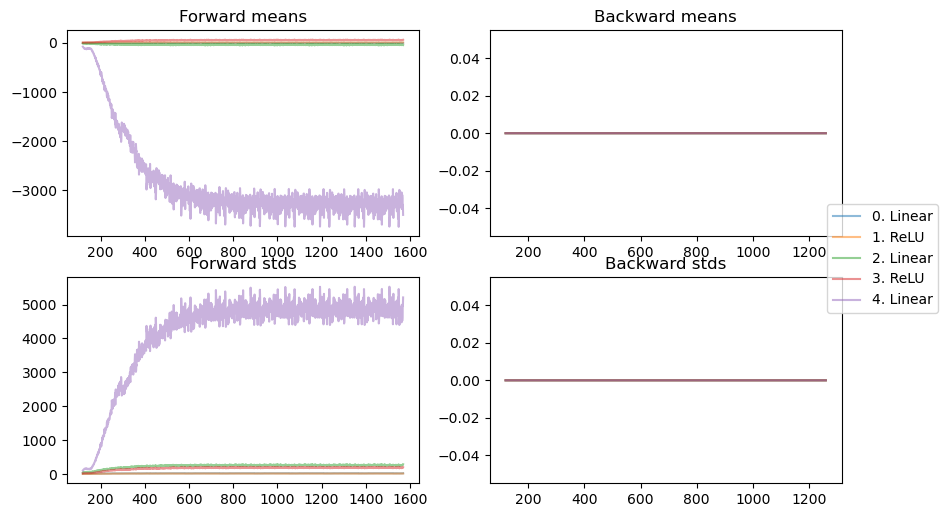

Sliceable plot. Can...
- p[a:b]: to focus on a specific range of the plot
- p.log: to display plot using log scale

In [237]:
l.HookModule[2:7].plot()[120:]